# Home Depot Product Search Relevance 

# 1. Background

In this project, we are given a dataset that contains a number of products and real customer search terms from Home Depot's website. The challenge is to predict a relevance score for the provided combinations of search terms and products. To create the ground truth labels, Home Depot has crowdsourced the search/product pairs to multiple human raters. The relevance is a number between 1 (not relevant) to 3 (highly relevant).

We are provided with the following information:

    id - a unique Id field which represents a (search_term, product_uid) pair
    product_uid - an id for the products
    product_title - the product title
    product_description - the text description of the product (may contain HTML content)
    search_term - the search query
    name - an attribute name
    value - the attribute's value
    relevance - the average of the relevance ratings for a given id

Our task is to build up a regression model, and for each id in the test set, it should predict a relevance, which is a real number in [1,3].

# 2. Data Explore

First of all, we want to read data to dataframes.

In [160]:
#To succesfully run this script, you need to install nltk package.
import numpy as np
import pandas as pd

In [161]:
#read data
df_train = pd.read_csv('../data/train.csv',encoding="ISO-8859-1")
df_test = pd.read_csv('../data/test.csv',encoding="ISO-8859-1")
attr = pd.read_csv("../data/attributes.csv")
desc = pd.read_csv('../data/product_descriptions.csv', encoding="ISO-8859-1")

We first can explore some basic information in train and test set.

In [162]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74067 entries, 0 to 74066
Data columns (total 5 columns):
id               74067 non-null int64
product_uid      74067 non-null int64
product_title    74067 non-null object
search_term      74067 non-null object
relevance        74067 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 2.8+ MB


In [163]:
len(df_train['product_uid'].unique())

54667

In [164]:
len(df_test['product_uid'].unique())

97460

Based on number of products in training set and test set, there are around twice more numbers of products in test set than training set, which means the features(word) of half instances in test set might have never showed up in training set. This could be a big challenge for prediction on test set, as there could be many new features if word2vec or one-hot features were used. 


I also explored the distribution of relevance in training set.

In [85]:
df_train["relevance"].describe()

count    74067.000000
mean         2.381634
std          0.533984
min          1.000000
25%          2.000000
50%          2.330000
75%          3.000000
max          3.000000
Name: relevance, dtype: float64

In [86]:
%matplotlib inline 
import matplotlib.pyplot as plt

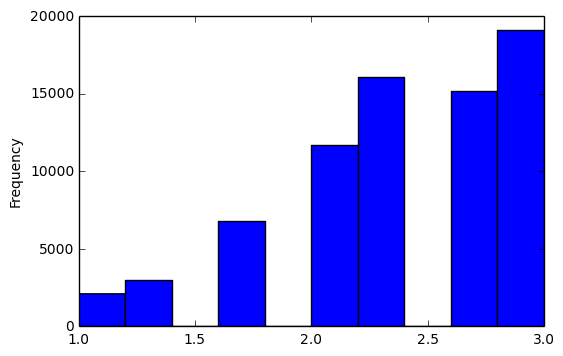

In [87]:
df_train["relevance"].plot.hist()

The relevance is skewed in training data, while as the frequency is high enough for regression, this is not a big problem.

Then training set and test set were combined together.

In [165]:
df_all = pd.concat((df_train, df_test), axis=0, ignore_index=True)

In [166]:
df_all

,id,product_title,product_uid,relevance,search_term
0,2,Simpson Strong-Tie 12-Gauge Angle,100001,3.00,angle bracket
1,3,Simpson Strong-Tie 12-Gauge Angle,100001,2.50,l bracket
2,9,BEHR Premium Textured DeckOver 1-gal. #SC-141 ...,100002,3.00,deck over
3,16,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,100005,2.33,rain shower head
4,17,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,100005,2.67,shower only faucet
5,18,Whirlpool 1.9 cu. ft. Over the Range Convectio...,100006,3.00,convection otr
6,20,Whirlpool 1.9 cu. ft. Over the Range Convectio...,100006,2.67,microwave over stove
7,21,Whirlpool 1.9 cu. ft. Over the Range Convectio...,100006,3.00,microwaves
8,23,Lithonia Lighting Quantum 2-Light Black LED Em...,100007,2.67,emergency light
9,27,House of Fara 3/4 in. x 3 in. x 8 ft. MDF Flut...,100009,3.00,mdf 3/4


As different product has different numbers of attributes in attribute file, I want to combine them together, so it can be treated as anouther description feature.

In [167]:
#join values of all names of one product
def join_values(attribute):
    #name = attribute["name"]
    values = attribute["value"]
    values_str= [str(i) for i in values.tolist()]
    result= " ".join(values_str)
    return result
    
newAttr= attr.groupby(["product_uid"]).apply(join_values)

In [168]:
attr = newAttr.reset_index(name="product_attributes")

In [169]:
attr

,product_uid,product_attributes
0,100001.0,Versatile connector for various 90° connection...
1,100002.0,"Brush,Roller,Spray 6.63 in 7.76 in 6.63 in Rev..."
2,100003.0,Yes Slightly narrower for tighter spaces Desig...
3,100004.0,8.56 Positive power tolerance (0 to +5-Watt) A...
4,100005.0,Combo Tub and Shower No Includes the trim kit ...
5,100006.0,Over the Range Microwave 18.5 in 17.13 in 29.9...
6,100007.0,Ni-Cad .Built-In LED Advanced LED technology i...
7,100008.0,.375 in 1.5 in .375 in For metal to metal fast...
8,100009.0,Door & Window Made of primed MDF Can be painte...
9,100010.0,No Can be used with all valley View lawn edgin...


In [170]:
#two new features, product description and attributes, are merged to dataframe
df_all = pd.merge(df_all, desc, how='left', on='product_uid')
df_all = pd.merge(df_all, attr, how="left", on="product_uid")


In [96]:
df_all.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 240760 entries, 0 to 240759
Data columns (total 7 columns):
id                     240760 non-null int64
product_title          240760 non-null object
product_uid            240760 non-null int64
relevance              74067 non-null float64
search_term            240760 non-null object
product_description    240760 non-null object
product_attributes     194935 non-null object
dtypes: float64(1), int64(2), object(4)
memory usage: 14.7+ MB


In [97]:
#fill in the missing values in product_attributes
df_all["product_attributes"] = df_all["product_attributes"].fillna("")

In [98]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 240760 entries, 0 to 240759
Data columns (total 7 columns):
id                     240760 non-null int64
product_title          240760 non-null object
product_uid            240760 non-null int64
relevance              74067 non-null float64
search_term            240760 non-null object
product_description    240760 non-null object
product_attributes     240760 non-null object
dtypes: float64(1), int64(2), object(4)
memory usage: 14.7+ MB


# text pre-processing

Text pre-processing was splited to two phases: First, substitution was performed to clean the meaningless symbols and synonyms. Then Stemmers remove morphological affixes from words, leaving only the word stem. 

In [99]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer('english')
#stemmer

In [171]:
#text cleaning for "product_title", "product_description", and "search_term"
def stem_word(line):
    line = line.lower()
    line = line.replace("  "," ")
    line = line.replace(",","") #transfer format like 10,000 to 10000
    line = line.replace("one","1")
    line = line.replace("two","2")
    line = line.replace("three","3")
    line = line.replace("four","4")
    line = line.replace("five","5")
    line = line.replace("six","6")
    line = line.replace("seven","7")
    line = line.replace("eight","8")
    line = line.replace("nine","9")
    line = line.replace("zero","0")
    line = line.replace("(","")
    line = line.replace(")","")
    
    words = line.split(" ")
    newWords=[]
    for word in words:
        newWords.append(stemmer.stem(word))
    return " ".join(newWords)

In [113]:
df_all["product_title"] = df_all["product_title"].apply(stem_word)

In [102]:
df_all["product_title"]

0                            simpson strong-ti 12-gaug angl
1                            simpson strong-ti 12-gaug angl
2         behr premium textur deckov 1-gal. #sc-141 tugb...
3         delta vero 1-handl shower onli faucet trim kit...
4         delta vero 1-handl shower onli faucet trim kit...
5         whirlpool 1.9 cu. ft. over the rang convect mi...
6         whirlpool 1.9 cu. ft. over the rang convect mi...
7         whirlpool 1.9 cu. ft. over the rang convect mi...
8         lithonia light quantum 2-light black led emerg...
9         hous of fara 3/4 in. x 3 in. x 8 ft. mdf flute...
10                valley view industri metal stake (4-pack)
11        toro person pace recycl 22 in. variabl speed s...
12        toro person pace recycl 22 in. variabl speed s...
13        toro person pace recycl 22 in. variabl speed s...
14        hampton bay caramel simpl weav bamboo rollup s...
15        insinker sinktop switch singl outlet for insin...
16        sunjoy calai 8 ft. x 5 ft. x 8

In [106]:
df_all["product_description"] = df_all["product_description"].apply(stem_word)

In [110]:
df_all["search_term"] = df_all["search_term"].apply(stem_word)

In [172]:
#"product_attributes" need to be decoded with utf-8, so a new stem_word function was used
def stem_word2(line):
    line = line.lower()
    line = line.replace("  "," ")
    line = line.replace(",","") #transfer format like 10,000 to 10000
    line = line.replace("one","1")
    line = line.replace("two","2")
    line = line.replace("three","3")
    line = line.replace("four","4")
    line = line.replace("five","5")
    line = line.replace("six","6")
    line = line.replace("seven","7")
    line = line.replace("eight","8")
    line = line.replace("nine","9")
    line = line.replace("zero","0")
    line = line.replace("(","")
    line = line.replace(")","")
    
    words = line.split(" ")
    newWords=[]
    for word in words:
        newWords.append(stemmer.stem(word.decode('utf-8','ignore')))
    return " ".join(newWords)



In [118]:
df_all["product_attributes"] = df_all["product_attributes"].apply(stem_word2)

In [122]:
#write all text features to file
df_all.to_csv('df_word.csv', encoding="utf-8")

In [123]:
df_all

,id,product_title,product_uid,relevance,search_term,product_description,product_attributes
0,2,simpson strong-ti 12-gaug angl,100001,3.00,angl bracket,not onli do angl make joint stronger they also...,versatil connector for various 90° connect and...
1,3,simpson strong-ti 12-gaug angl,100001,2.50,l bracket,not onli do angl make joint stronger they also...,versatil connector for various 90° connect and...
2,9,behr premium textur deckov 1-gal. #sc-141 tugb...,100002,3.00,deck over,behr premium textur deckov is an innov solid c...,brushrollerspray 6.63 in 7.76 in 6.63 in reviv...
3,16,delta vero 1-handl shower on faucet trim kit i...,100005,2.33,rain shower head,updat your bathroom with the delta vero single...,combo tub and shower no includ the trim kit on...
4,17,delta vero 1-handl shower on faucet trim kit i...,100005,2.67,shower on faucet,updat your bathroom with the delta vero single...,combo tub and shower no includ the trim kit on...
5,18,whirlpool 1.9 cu. ft. over the rang convect mi...,100006,3.00,convect otr,achiev delici result is almost effortless with...,over the rang microwav 18.5 in 17.13 in 29.94 ...
6,20,whirlpool 1.9 cu. ft. over the rang convect mi...,100006,2.67,microwav over stove,achiev delici result is almost effortless with...,over the rang microwav 18.5 in 17.13 in 29.94 ...
7,21,whirlpool 1.9 cu. ft. over the rang convect mi...,100006,3.00,microwav,achiev delici result is almost effortless with...,over the rang microwav 18.5 in 17.13 in 29.94 ...
8,23,lithonia light quantum 2-light black led emerg...,100007,2.67,emerg light,the quantum adjust 2-light led black emerg lig...,ni-cad .built-in led advanc led technolog is d...
9,27,hous of fara 3/4 in. x 3 in. x 8 ft. mdf flute...,100009,3.00,mdf 3/4,get the hous of fara 3/4 in. x 3 in. x 8 ft. m...,door & window made of prime mdf can be paint t...


In [136]:
#save a copy
df_copy = df_all.copy()

# Feature Engineering

Based on the product exploration of training and test set, I don't think word2vec or one-hot vector is a good choice for this dataset. One reason is that there are many new features haven't showed up in training set, so the feature space is incomplete, which brings unaviodable error, the other reason is, as the dataset is large, there could be a huge number of features if we use word2vec. 

I think the relevance is most related to the similarity between search term and product itself. So I decided to create features that describe the similarity between search term and the product. In this stage, I created number of common words as featrues, which is the number of the same word that showed up in both search term and product descriptions.

In [132]:
#return number of common words in c1 and c2
def common_words(c1, c2):
    result=[]
    for term, title in zip(c1, c2):
        term_list = term.split(" ")
        title_list = title.split(" ")
        result.append(sum(int(i in title_list) for i in term_list))
    return result
    

In [134]:
#calculate number of common words between search term and title, description, attributes 
search_term = df_all["search_term"]
product_title = df_all["product_title"]
product_description = df_all["product_description"]
product_attributes = df_all["product_attributes"]

In [139]:
common_search_title = common_words(search_term, product_title)
common_search_description = common_words(search_term, product_description)
common_search_attributes = common_words(search_term, product_attributes)

In [140]:
df_all["common_search_title"] = common_search_title
df_all["common_search_description"] = common_search_description
df_all["common_search_attributes"] = common_search_attributes

In [141]:
df_all

,id,product_title,product_uid,relevance,search_term,product_description,product_attributes,common_search_title,common_search_description,common_search_attributes
0,2,simpson strong-ti 12-gaug angl,100001,3.00,angl bracket,not onli do angl make joint stronger they also...,versatil connector for various 90° connect and...,1,1,1
1,3,simpson strong-ti 12-gaug angl,100001,2.50,l bracket,not onli do angl make joint stronger they also...,versatil connector for various 90° connect and...,0,0,0
2,9,behr premium textur deckov 1-gal. #sc-141 tugb...,100002,3.00,deck over,behr premium textur deckov is an innov solid c...,brushrollerspray 6.63 in 7.76 in 6.63 in reviv...,0,1,1
3,16,delta vero 1-handl shower on faucet trim kit i...,100005,2.33,rain shower head,updat your bathroom with the delta vero single...,combo tub and shower no includ the trim kit on...,1,1,2
4,17,delta vero 1-handl shower on faucet trim kit i...,100005,2.67,shower on faucet,updat your bathroom with the delta vero single...,combo tub and shower no includ the trim kit on...,3,3,3
5,18,whirlpool 1.9 cu. ft. over the rang convect mi...,100006,3.00,convect otr,achiev delici result is almost effortless with...,over the rang microwav 18.5 in 17.13 in 29.94 ...,1,1,1
6,20,whirlpool 1.9 cu. ft. over the rang convect mi...,100006,2.67,microwav over stove,achiev delici result is almost effortless with...,over the rang microwav 18.5 in 17.13 in 29.94 ...,2,2,2
7,21,whirlpool 1.9 cu. ft. over the rang convect mi...,100006,3.00,microwav,achiev delici result is almost effortless with...,over the rang microwav 18.5 in 17.13 in 29.94 ...,1,1,1
8,23,lithonia light quantum 2-light black led emerg...,100007,2.67,emerg light,the quantum adjust 2-light led black emerg lig...,ni-cad .built-in led advanc led technolog is d...,2,2,2
9,27,hous of fara 3/4 in. x 3 in. x 8 ft. mdf flute...,100009,3.00,mdf 3/4,get the hous of fara 3/4 in. x 3 in. x 8 ft. m...,door & window made of prime mdf can be paint t...,2,2,1


I also created features showing the number of words in each text feature. Intuitively, if a product has longer descriptions itself, it is more possible that it is related to search term, or it is more helpful to judge if the product is relevant to the search term.

In [142]:
df_all["len_search_term"] = [ len(term.split(" ")) for term in search_term]

In [144]:
df_all["len_product_title"] = [ len(title.split(" ")) for title in product_title]
df_all["len_product_description"] = [ len(desc.split(" ")) for desc in product_description]
df_all["len_product_attributes"] = [ len(attribute.split(" ")) for attribute in product_attributes]

In [150]:
#drop text features
df = df_all.drop(["id", "product_title", "search_term", "product_description", "product_attributes"], axis=1)

In [152]:
#split train and test set
train = df[:len(df_train)]
train

,product_uid,relevance,common_search_title,common_search_description,common_search_attributes,len_search_term,len_product_title,len_product_description,len_product_attributes
0,100001,3.00,1,1,1,2,4,129,67
1,100001,2.50,0,0,0,2,4,129,67
2,100002,3.00,0,1,1,2,11,167,148
3,100005,2.33,1,1,2,3,13,104,101
4,100005,2.67,3,3,3,3,13,104,101
5,100006,3.00,1,1,1,2,15,490,431
6,100006,2.67,2,2,2,3,15,490,431
7,100006,3.00,1,1,1,1,15,490,431
8,100007,2.67,2,2,2,2,9,120,105
9,100009,3.00,2,2,1,2,14,82,51


In [156]:
test = df[len(df_train):]
test = test.drop(["relevance"], axis=1)

In [ ]:
'''
steps:
1. data cleaning:
    replace "," to " "
    replace "." to " "
    ...
    Synonyms substitution

2. feature engineering
    length of query
    length of description
    TFIDF

3. model building
    RF, GBM
4. model optimization
    paramgridbuilder()


'''